# 讀資料

In [322]:
import os
import pandas as pd

start = pd.to_datetime("2022-10-01")
end = pd.to_datetime("2022-10-21")

parent_dir = "tick_data"
data_dict = {}
for filename in os.listdir(parent_dir):
    date = pd.to_datetime(filename[15:-4])
    if date >= start and date <= end: 
        data = pd.read_csv(os.path.join(parent_dir, filename), header = None)        
        data.columns = ["id", "price", "qty", "quoteQty", "time", "isBuyerMaker", "isBestMatch"]
        data = data.drop(["isBestMatch"], axis = 1)
        
        #data = data.set_index("id")
        data = data.set_index("time")
        data.index = pd.to_datetime(data.index, unit = "ms")
        data["isBuyerMaker"] = data["isBuyerMaker"].replace(True, -1).replace(False, 1)
        data["quoteQty_sign"] = data["quoteQty"] * data["isBuyerMaker"]
        data_dict[date] = data
        


# 策略邏輯
- 近``num_ticks``個tick的內外盤成交金額(若為內盤成交則金額為負，若為外盤成交金額為正)總和小於進場門檻時買進現貨
- 近``num_ticks``個tick的內外盤成交金額(若為內盤成交則金額為負，若為外盤成交金額為正)總和大於出場門檻時賣出現貨
- 進場門檻: ``昨日總和序列的平均-N倍昨日總和序列的標準差的門檻值``
- 出場門檻: ``昨日總和序列的平均+N倍昨日總和序列的標準差的門檻值``
- 為了確保有足夠的運算時間，昨日的總和序列僅取到``23:59:59``

# 策略訊號視覺化 (10/2 ~ 10/21)

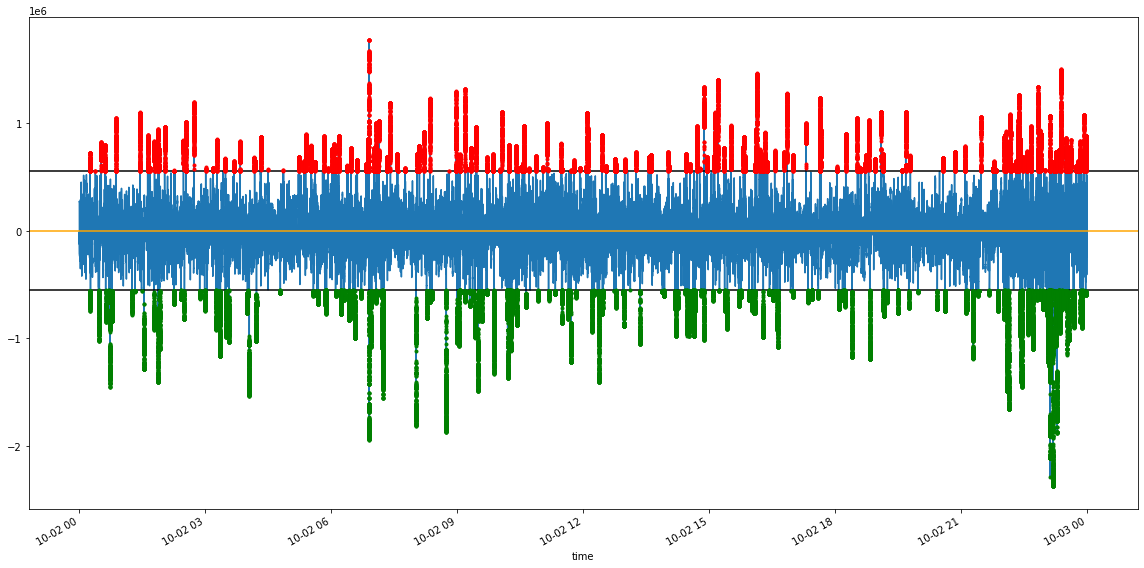

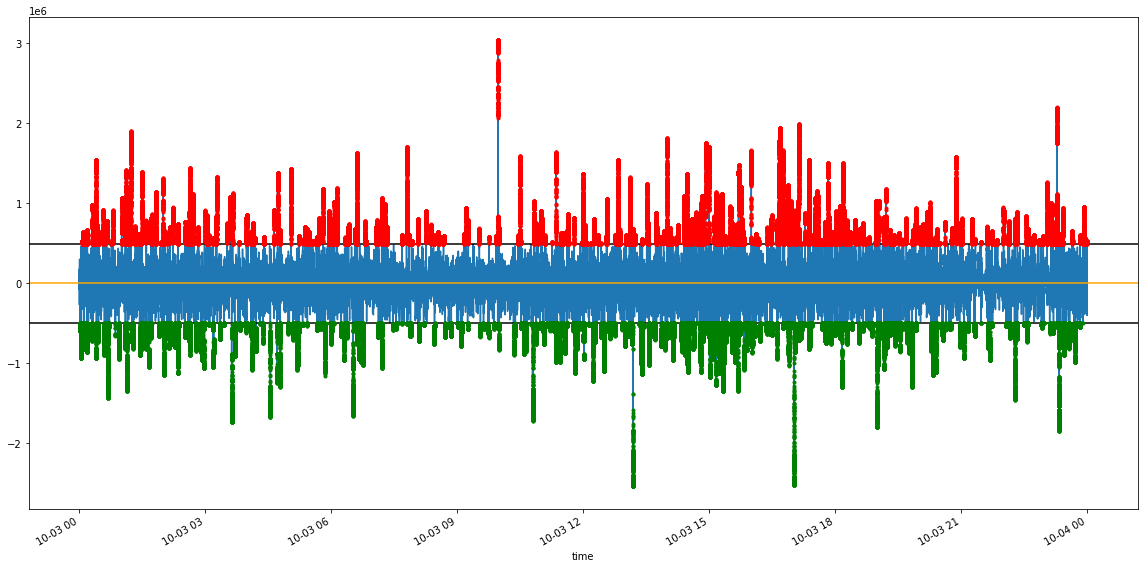

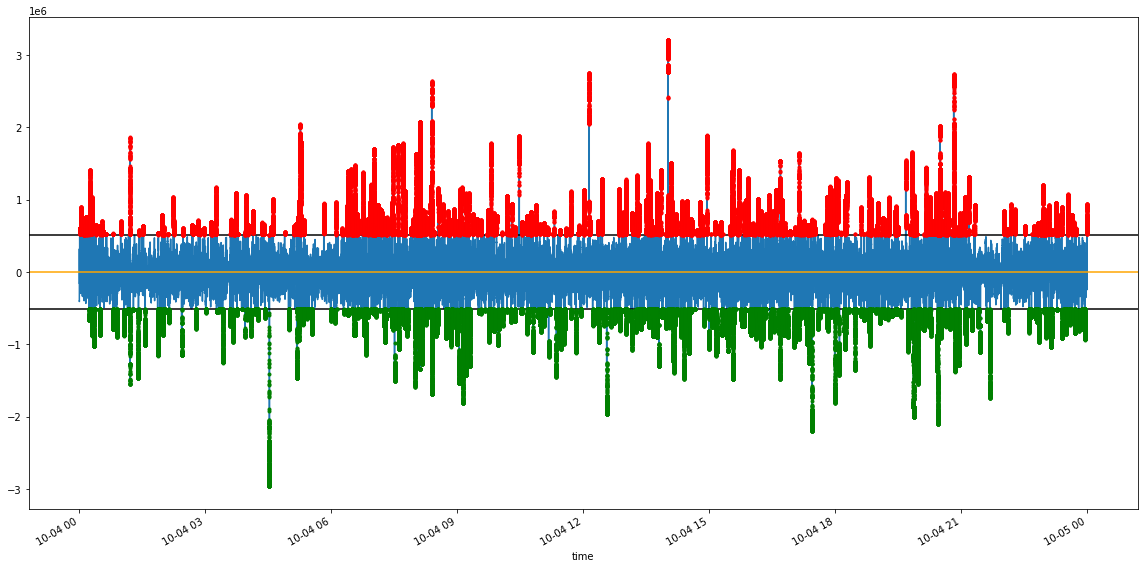

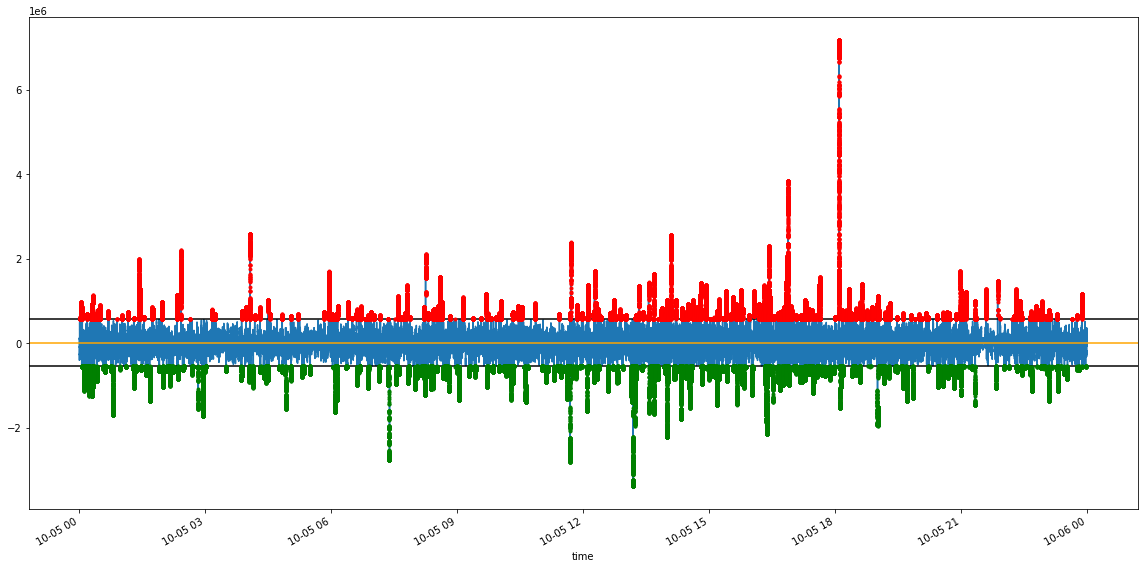

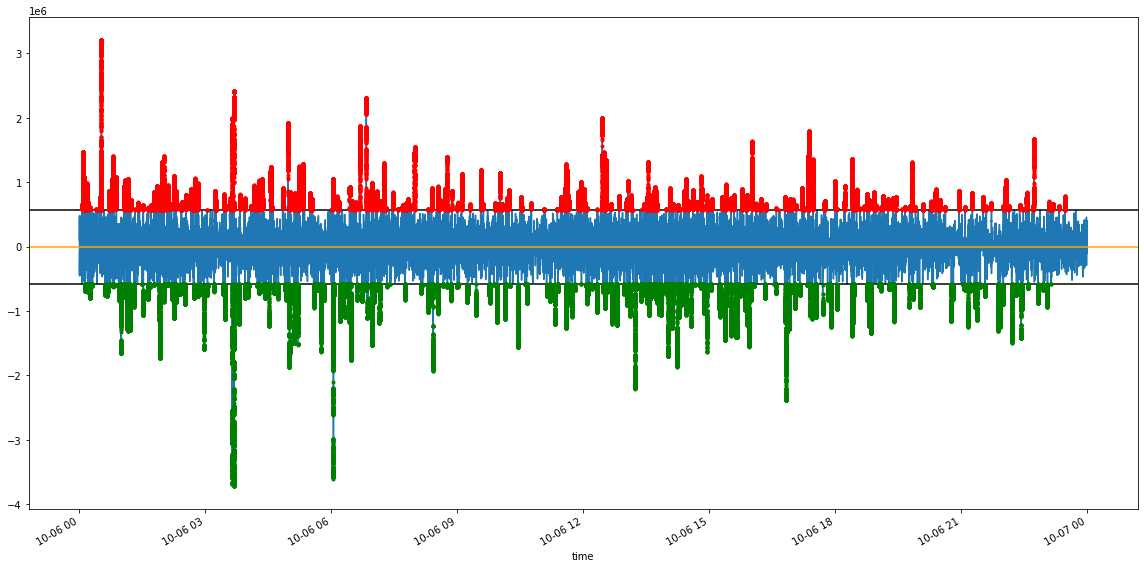

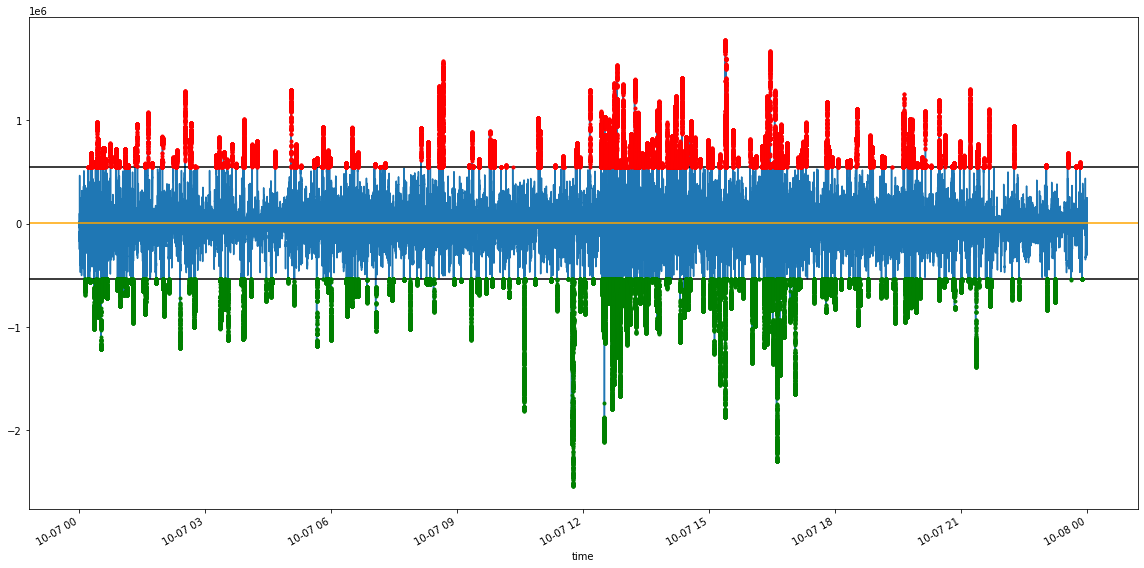

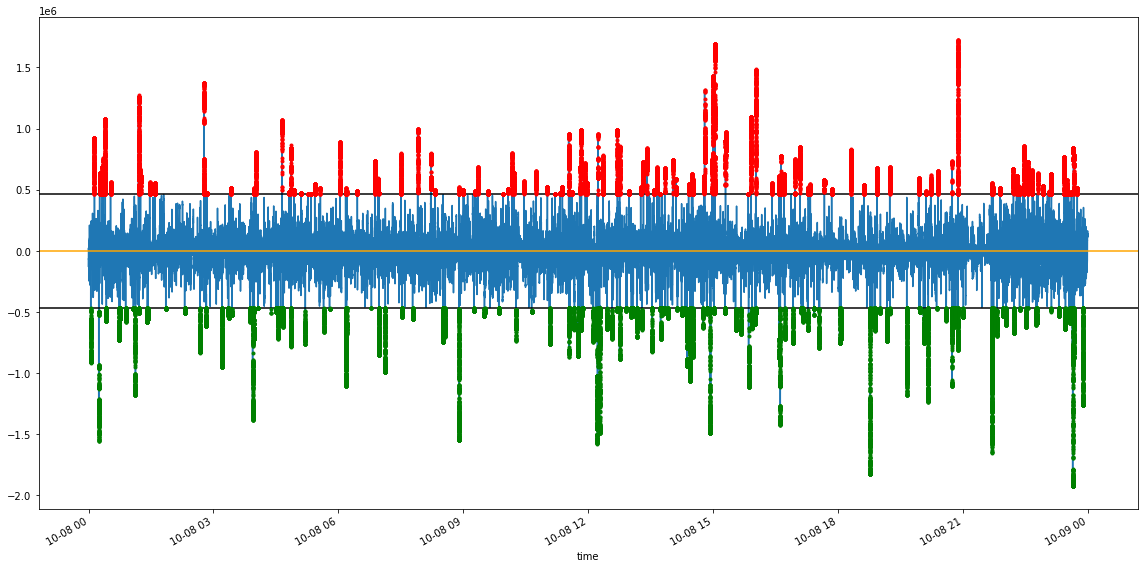

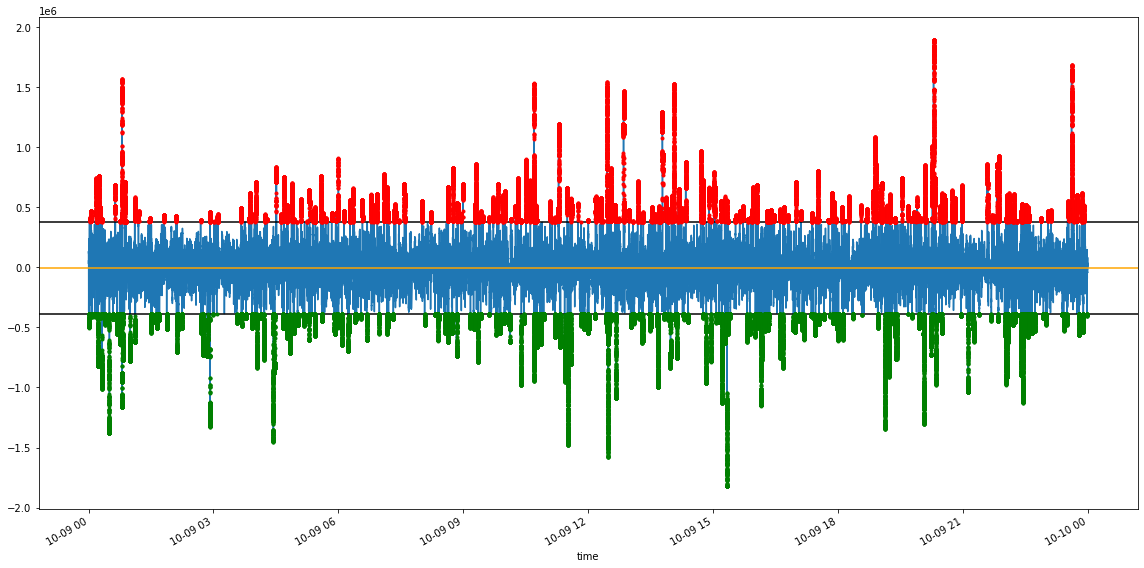

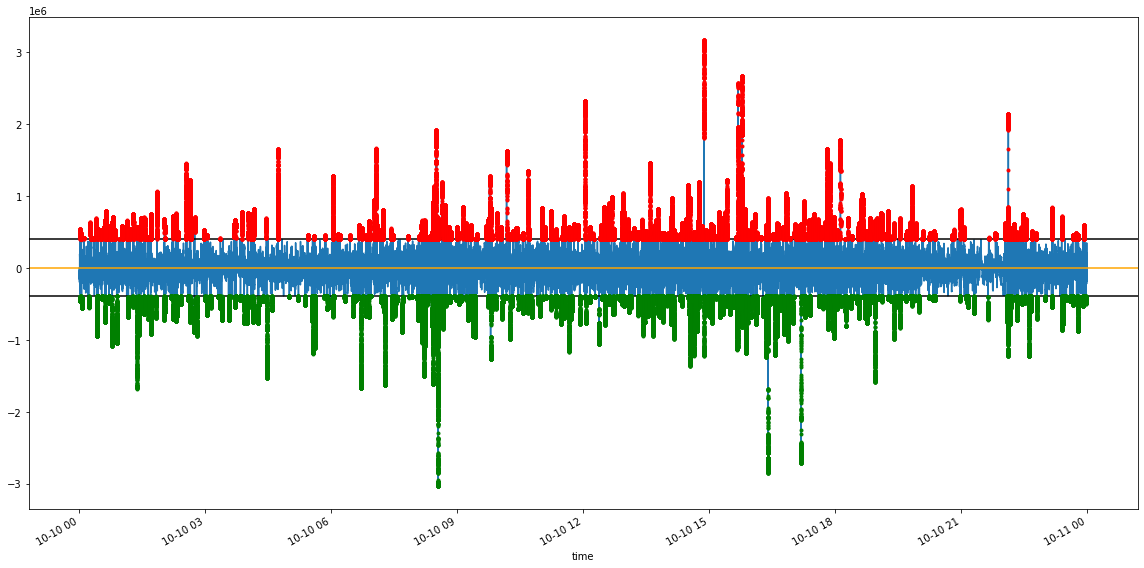

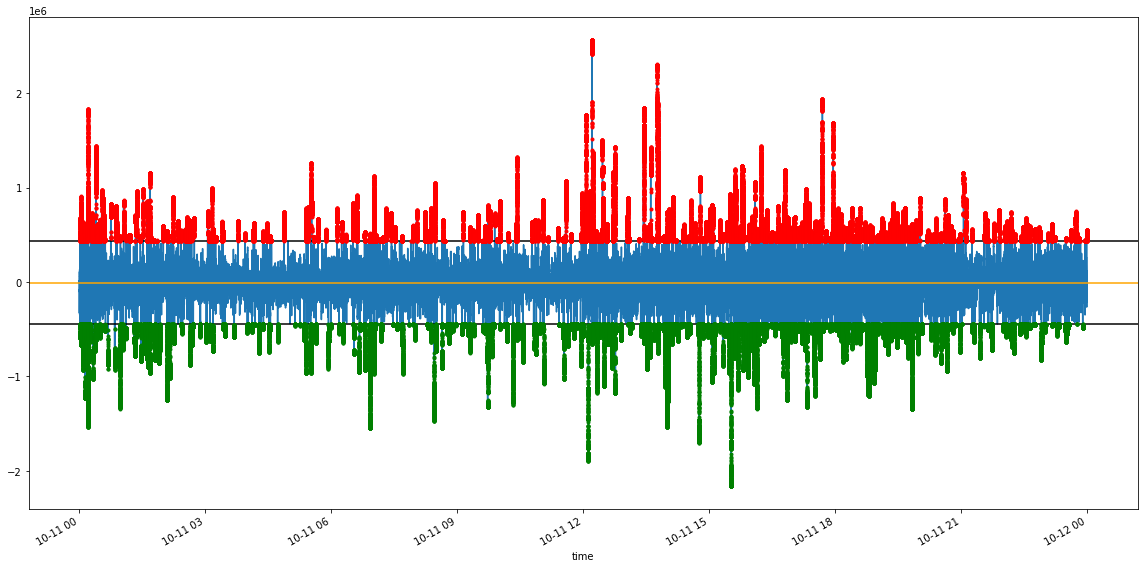

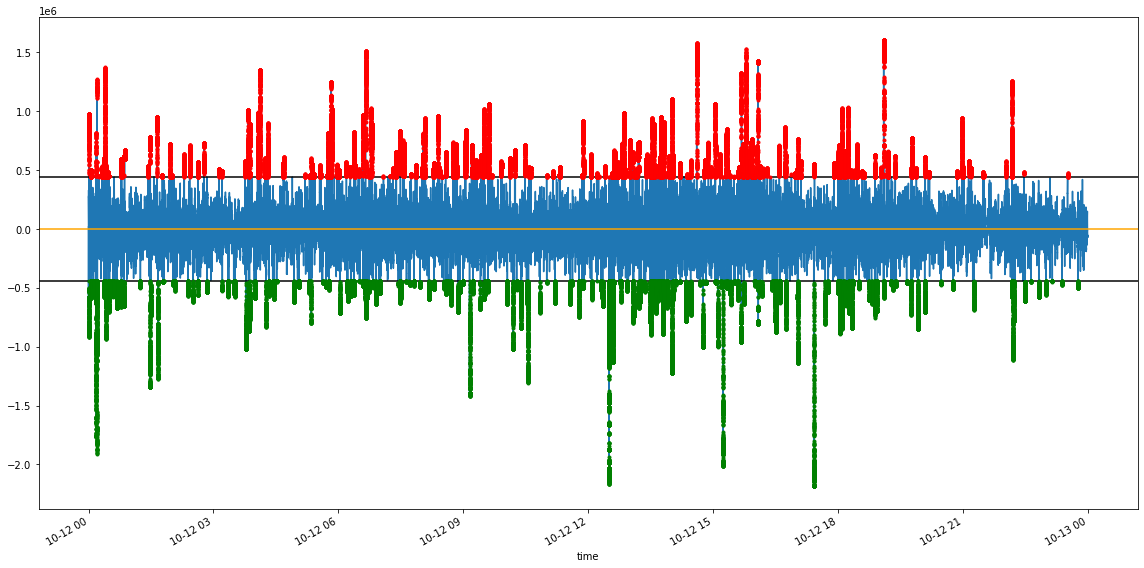

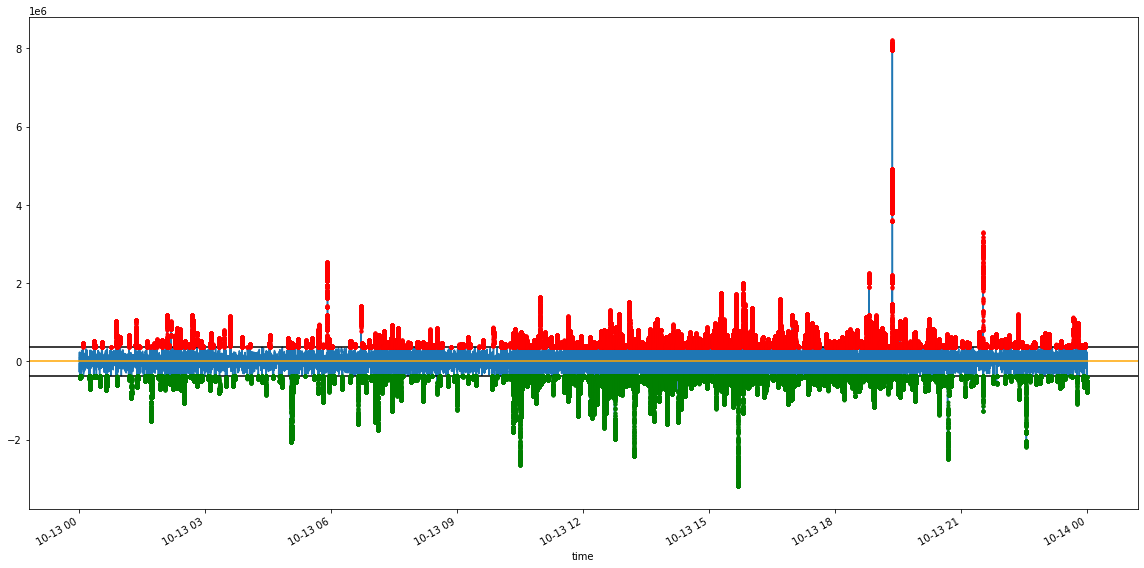

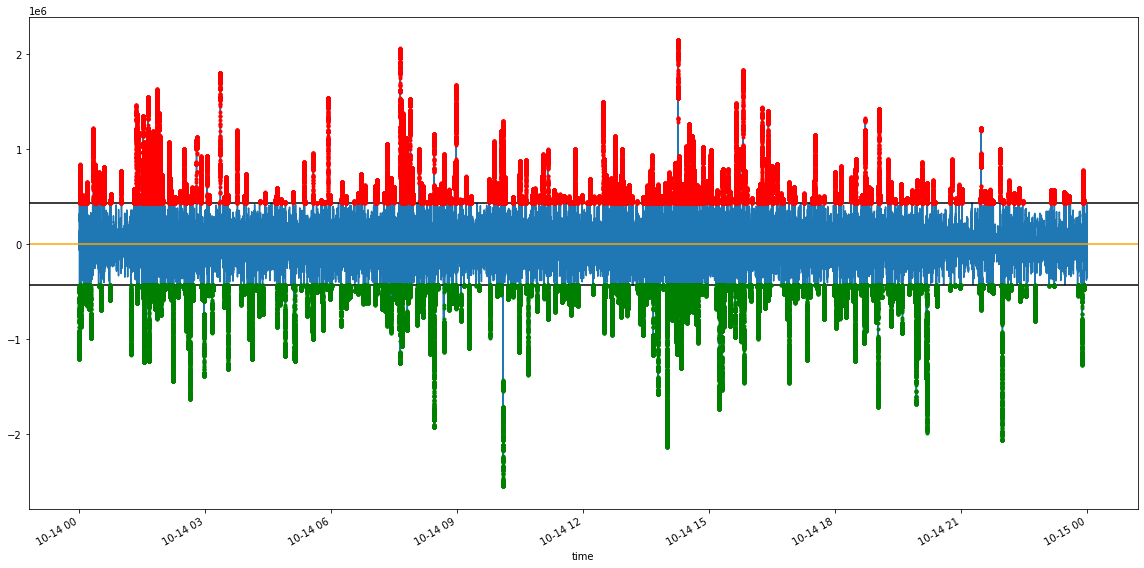

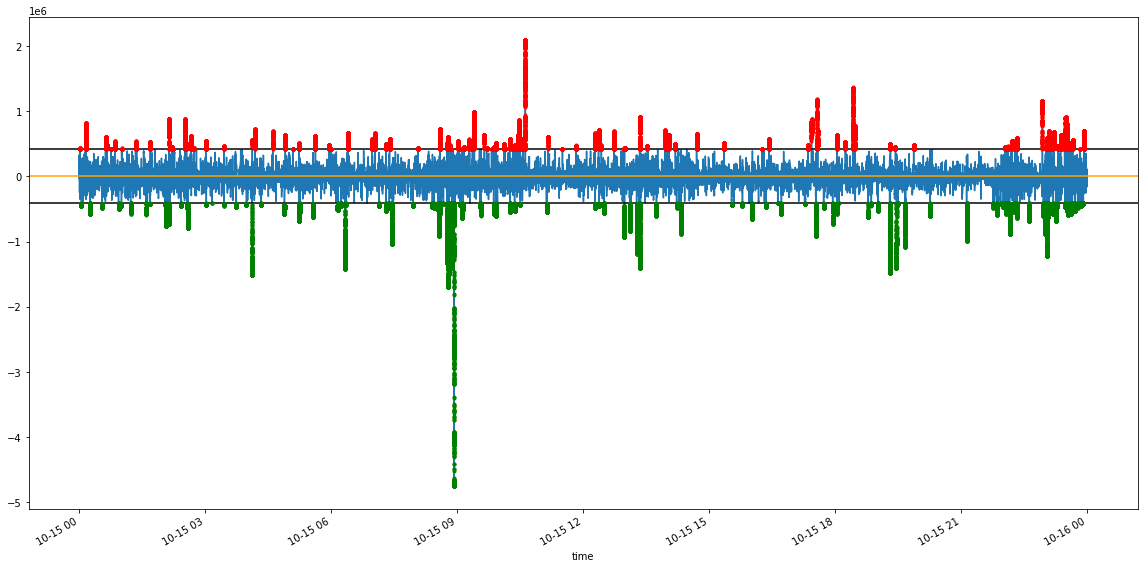

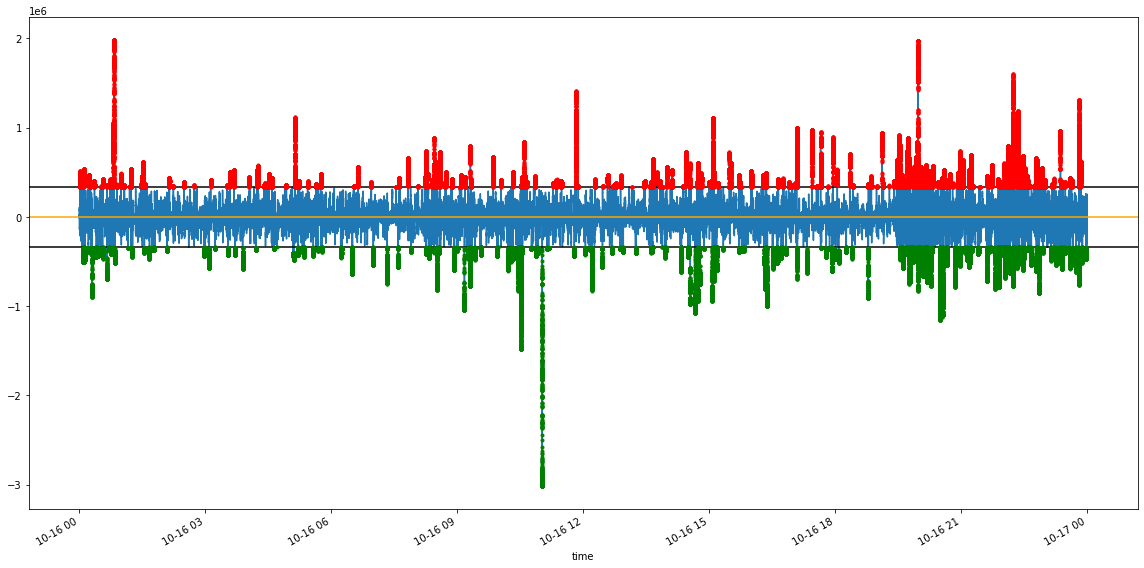

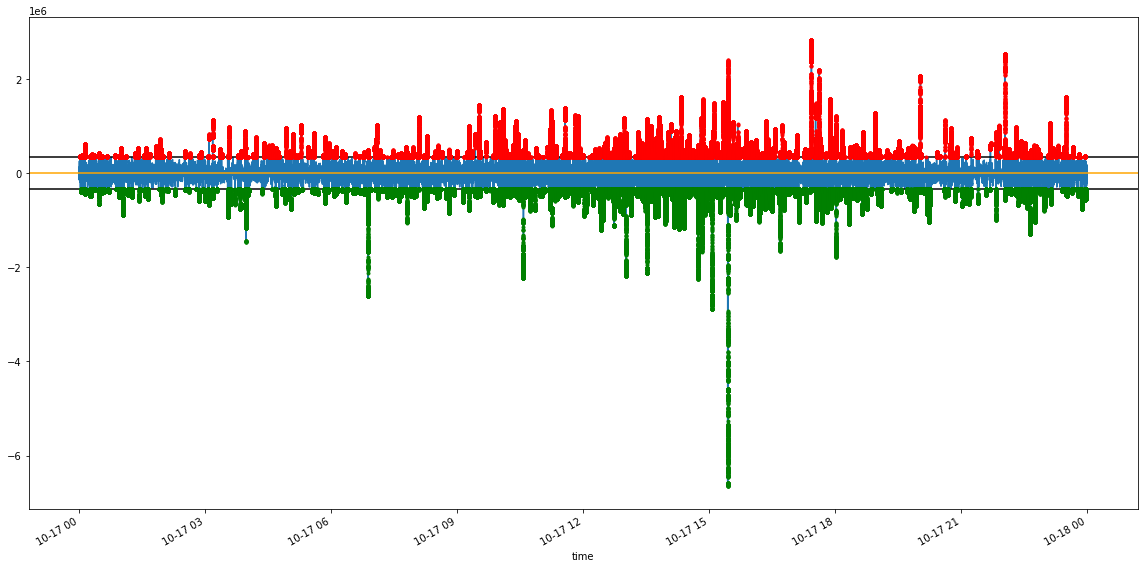

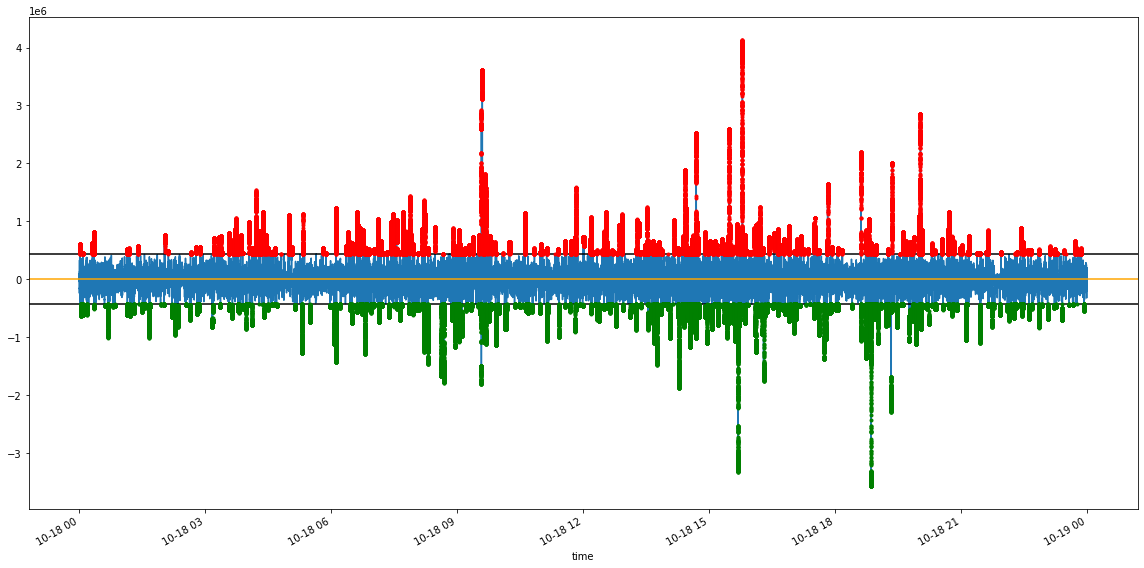

In [ ]:
%%time
from matplotlib import pyplot as plt

keys = list(data_dict.keys())
num_ticks = 500

for i, j in zip(keys, keys[1:]):
    data_pre = data_dict[i]
    data_pos = data_dict[j]
    data_pos = pd.concat([data_pre.iloc[-num_ticks+1:], data_pos])
    
    series_pre = data_pre["quoteQty_sign"].rolling(num_ticks).sum().dropna()
    series_pos = data_pos["quoteQty_sign"].rolling(num_ticks).sum().dropna()
    
    series_pre_mean = series_pre.between_time("00:00:00", "23:59:59").mean()
    series_pre_std = series_pre.between_time("00:00:00", "23:59:59").std()
    
    entry = (series_pos < series_pre_mean - series_pre_std*2)
    exit = (series_pos > series_pre_mean + series_pre_std*2)
    
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [16, 8]
    plt.rcParams["figure.autolayout"] = True
    
    series_pos.plot(ax=ax)
    ax.axhline(y=series_pre_mean, color = "orange")
    ax.axhline(y=series_pre_mean + series_pre_std*2, color = "black")
    ax.axhline(y=series_pre_mean - series_pre_std*2, color = "black")
    
    series_pos[entry].plot(style='.', color = "green")
    series_pos[exit].plot(style='.', color = "red")

    plt.show()

# 回測

## 多單進場
1. 當下的tick出現後
2. 計算包含當下tick的近``num_ticks``個tick的內外盤成交金額(若為內盤成交則金額為負，若為外盤成交金額為正)總和
3. 在金額還沒買滿的條件下，若該總和小於由``昨日全部總和平均-N倍昨日總和標準差的門檻值``，且該tick為內盤成交，則掛入價格為該tick成交價的limit買單 (這邊加上「tick為內盤成交」是為了增加掛出去的價格在內盤的機率)
4. 回測上，單子到交易所之後，刪單到之前，的tick的成交價 < 掛出價格，且為內盤成交，則視為有吃到該tick的成交金額

## 多單出場
1. 當下的tick出現後
2. 計算包含當下tick的近``num_ticks``個tick的內外盤成交金額(若為內盤成交則金額為負，若為外盤成交金額為正)總和
3. 在已買進金額>0的條件下，若該總和大於由``昨日全部總和平均+N倍昨日總和標準差的門檻值``，且該tick為外盤成交，則掛入價格為該tick成交價的limit賣單 (這邊加上「tick為外盤成交」是為了增加掛出去的價格在盤的機率)
4. 回測上，單子到交易所之後，刪單到之前，的tick的成交價 > 掛出價格，且為外盤成交，則視為有賣到該tick的成交金額

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
%%time

keys = list(data_dict.keys())

# 策略參數
num_ticks = 500
num_stds = 2
delay_ms = 1

# 回測參數
fee = 0.00/100 # 手續費
cash = 100000 # 起始資金 
btc = 0 # 起始比特幣
asset = cash # 起始資產總值

assets = [] # 存每次進出時，當下的資產總值
timestamps = [] # 存每次進出時，當下的時間

entry_action = False # True: 出了買進訊號，在等待掛單
exit_action = False # True: 出了賣出訊號，在等待掛單

arrive_info = None # 非None: 單子抵達交易所，在等待成交或被刪單
end_info = None # 非None: 單子成交或被刪單，在等待下次訊號

for i, j in zip(keys, keys[1:]):
    print(j) # print(回測日期)
    
    # 讀昨天的資料，並計算昨日總和序列的平均跟標準差
    data_pre = data_dict[i]
    series_pre = data_pre["quoteQty_sign"].rolling(num_ticks).sum().dropna()
    series_pre_mean = series_pre.between_time("00:00:00", "23:59:59").mean() # 確保實單上，在快跨日要換門檻值時，有足夠的運算時間，
    series_pre_std = series_pre.between_time("00:00:00", "23:59:59").std() # 昨日的總和序列僅取到23:59:59
    
    # 今日的資料
    data_pos = data_dict[j]
    data_pos = pd.concat([data_pre.iloc[-num_ticks+1:], data_pos]) # 把昨日資料尾端接在今日資料前面，確保今日的訊號可以從00:00:00開始算
    data_pos = data_pos.reset_index().set_index("id") # 以交易所給的id為iteration的依據
    
    # 計算今日的總和序列與進出場訊號
    series_pos = data_pos["quoteQty_sign"].rolling(num_ticks).sum().dropna()
    entry_condition = (series_pos < series_pre_mean - series_pre_std*num_stds)
    exit_condition = (series_pos > series_pre_mean + series_pre_std*num_stds)
    
    progress = tqdm(total = len(series_pos)) # 方便看回測到哪
    for idx in series_pos.index:
        current_info = data_pos.loc[idx]
        progress.update(1)
        
        if not entry_action and not exit_action: # 當前還沒出買進或賣出訊號
            if end_info is None: #True: 表示還沒有出過訊號，不用等
                pass
        
            else: #False: 出過訊號，要等一個delay (時間軸的最末端)，才能在算下一個訊號
                if (current_info["time"] - end_info["time"]).microseconds / 1000 <= delay_ms*1: 
                    continue
                else:
                    end_info = None
            
            # 出買進訊號，而且這個tick是內盤成交，而且還有錢
            if entry_condition[idx] and current_info["isBuyerMaker"] == -1 and cash > 0:
                entry_info = current_info # 存這個tick的資訊
                entry_action = True
                exit_action = False
                
            # 出賣出訊號，而且這個tick是外盤成交，而且有BTC要賣
            elif exit_condition[idx] and current_info["isBuyerMaker"] == 1 and btc > 0: 
                exit_info = current_info # 存這個tick的資訊
                entry_action = False
                exit_action = True

            else:
                pass
                
        elif entry_action: # 當前出買進訊號
            
            if (current_info["time"] - entry_info["time"]).microseconds / 1000 <= delay_ms*3: # 等單子送到交易所
                pass
            
            else: # 單子送到交易所開始洗價
                if arrive_info is None:
                    arrive_info = current_info # 紀錄送到後的第一個tick資訊
                
                if (current_info["time"] - arrive_info["time"]).microseconds / 1000 <= delay_ms*3: # 刪單還沒送到前就繼續洗價
                    if current_info["price"] < entry_info["price"] and current_info["isBuyerMaker"] == -1: # 這個tick成交價 < limit單價格，且內盤成交，才算吃到
                        amount = min(current_info["quoteQty"], cash/(1 + fee)) # 吃到的金額為，剩下的錢跟這個tick的成交金額取小
                        cash -= amount*(1 + fee)
                        btc += current_info["qty"] * amount/current_info["quoteQty"]

                        asset = cash + btc*current_info["price"]
                        assets.append(asset)
                        timestamps.append(current_info["time"])
                        
                else:
                    entry_action = False
                    exit_action = False
                    arrive_info = None
                    end_info = current_info
            
        elif exit_action:            
            if (current_info["time"] - exit_info["time"]).microseconds / 1000 <= delay_ms*3:
                pass
            
            else:
                if arrive_info is None:
                    arrive_info = current_info
                    
                if (current_info["time"] - arrive_info["time"]).microseconds / 1000 <= delay_ms*3:
                    if current_info["price"] > entry_info["price"] and current_info["isBuyerMaker"] == 1:
                        amount = min(current_info["qty"], btc)
                        btc -= amount
                        cash += current_info["quoteQty"] * amount/current_info["qty"] / (1 + fee)

                        asset = cash + btc*current_info["price"]
                        assets.append(asset)
                        timestamps.append(current_info["time"])
                        
                else:
                    entry_action = False
                    exit_action = False
                    arrive_info = None
                    end_info = current_info
            
        else:
            raise Exception("Error")

In [ ]:
plt.plot(timestamps, assets)
plt.show()